In [1]:
import pickle

import geopandas as gpd
from fancyimpute import IterativeImputer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Read Data

In [2]:
data = pd.read_csv('data/exercise_40_train.csv')
# By using the .head() and .dtypes methods, we will get a general understanding of how the data looks like.
# There are 101 columns in total. Columns types include Object, int64, and float64
# It is difficult to interpret the data and generate features without meaningful column names.
# Descriptive statistic is a good way to look into to understand the distribution of the values in this situation.
print(data.dtypes.unique())
data.head()

[dtype('int64') dtype('float64') dtype('O')]


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,0,0.165254,18.060003,Wed,1.077380,-1.339233,-1.584341,0.0062%,0.220784,1.816481,...,-0.397427,0.909479,no,5.492487,NaN,10.255579,7.627730,0,yes,104.251338
1,1,2.441471,18.416307,Friday,1.482586,0.920817,-0.759931,0.0064%,1.192441,3.513950,...,0.656651,9.093466,no,3.346429,4.321172,NaN,10.505284,1,yes,101.230645
2,1,4.427278,19.188092,Thursday,0.145652,0.366093,0.709962,-8e-04%,0.952323,0.782974,...,2.059615,0.305170,no,4.456565,NaN,8.754572,7.810979,0,yes,109.345215
3,0,3.925235,19.901257,Tuesday,1.763602,-0.251926,-0.827461,-0.0057%,-0.520756,1.825586,...,0.899392,5.971782,no,4.100022,1.151085,NaN,9.178325,1,yes,103.021970
4,0,2.868802,22.202473,Sunday,3.405119,0.083162,1.381504,0.0109%,-0.732739,2.151990,...,3.003595,1.046096,yes,3.234033,2.074927,9.987006,11.702664,0,yes,92.925935


In [3]:
# By using the describe method, we can identify that not all columns have the same number of variables. (x5, x11...)
# Null exist in some column and we will later on need to remove them through imputation
data.describe()

,y,x1,x2,x4,x5,x6,x8,x9,x10,x11,...,x89,x90,x91,x92,x94,x95,x96,x97,x98,x100
count,40000.000000,40000.000000,40000.000000,40000.000000,37572.000000,40000.000000,40000.000000,40000.000000,40000.000000,34890.000000,...,29309.000000,40000.000000,34741.000000,37565.000000,37660.000000,27396.000000,33362.000000,40000.000000,40000.000000,40000.000000
mean,0.145075,2.999958,20.004865,0.002950,0.005396,0.007234,0.004371,2.722334,0.490339,100.008988,...,10.767838,3.000166,0.001636,4.002896,3.969385,0.031886,10.525530,10.002814,0.497650,100.024743
std,0.352181,1.994490,1.604291,1.462185,1.297952,1.358551,1.447223,1.966828,1.029863,13.343010,...,3.732763,1.164411,1.468790,3.017420,1.473939,1.823091,1.437581,1.986984,0.500001,5.247514
min,0.000000,-3.648431,13.714945,-5.137161,-5.616412,-6.113153,-6.376810,-3.143438,-3.538129,50.526543,...,6.106024,-2.173310,-6.328126,-3.384399,-1.663063,-6.885150,8.210456,1.911272,0.000000,78.340735
25%,0.000000,1.592714,18.921388,-1.026798,-0.872354,-0.909831,-0.971167,1.340450,-0.207833,91.056682,...,7.927605,2.211125,-0.982679,1.610899,2.943758,-1.190682,9.397548,8.665103,0.000000,96.516856
50%,0.000000,2.875892,20.005944,0.002263,0.008822,0.007335,0.002226,2.498876,0.486926,100.020965,...,9.931831,2.998776,0.005664,4.099763,3.912526,0.001523,10.358355,9.994318,0.000000,100.024977
75%,0.000000,4.270295,21.083465,1.043354,0.892467,0.926222,0.985023,3.827712,1.182994,109.025025,...,12.710543,3.786751,0.989632,6.113157,4.930563,1.248742,11.448559,11.342574,1.000000,103.558762
max,1.000000,13.837591,27.086468,5.150153,5.698128,5.639372,5.869889,18.006669,4.724186,148.784484,...,38.566041,7.130058,6.868747,16.734658,11.669024,7.631773,18.725468,17.861580,1.000000,122.406809


In [4]:
# Separate Object, float, and integar variables

# Seperate response variable
y_df = data['y'].astype('int')
y_df.head()

# Object
category_df = data.loc[:,data.dtypes == np.object]
# Float
float_df = data.loc[:,data.dtypes == np.float64]
# Int
int_df = data.loc[:,data.dtypes == np.int64]
# The dependent variable y is also included in the int_df, we would want to exclude the column
int_df = int_df.drop(columns=['y'])

/tmp/ipykernel_20924/3941225013.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  category_df = data.loc[:,data.dtypes == np.object]


In [5]:
y_df.to_pickle('labels.pkl', compression='gzip')

### Categorical Columns

By applying the .describe() method to categorical columns, we will be able to gauge some of the column meanings. For example:
- `x3` should be the week column, but it has 14 unique value, which later might require some data cleaning in order to be in the correct format.
- `x7` is a column related to the percentage (%) of something, we can transfer it back to numerical column for better interpretation.
- `x19` is a column related to positive and negative value ($), we should transform it back to numerical column as well.
- `x24` might be the gender column
- `x31` and `x93` are columns providing yes or no answer, while `x99` only provides yes or null value.
- `x33` is the state column.
- `x39` is a column indicating miles, interestingly, the only unique answer is 5-10 miles, which it might not provide much meaning in our analysis.
- `x60` is the month column with exact 12 unique values.
- `x65` and `x77` are the highlight in this categorical data. `x65` It is a column related to which insurance company the record belongs to, includes `farmers`, `allstate`, `geico`, `progressive`, and `esurance`, and `x77` shows the brand of the car for the record, includes `mercedes`, `subaru`, `nissan`, `toyota`, `chevrolet` and null value.

In [6]:
category_df.describe()

,x3,x7,x19,x24,x31,x33,x39,x60,x65,x77,x93,x99
count,40000,40000,40000,36144,40000,32829,40000,40000,40000,30743,40000,27164
unique,14,663,40000,2,2,51,1,12,5,7,2,1
top,Wednesday,0.0022%,$-908.650758424405,female,no,California,5-10 miles,December,progressive,ford,no,yes
freq,4930,193,1,18158,34022,3393,40000,8136,10877,9005,35506,27164


In [7]:
# See what unique values within `x3`
print(category_df['x3'].unique())
        
category_df['x3'] = category_df['x3'].apply(lambda x: x[:3])
category_df = category_df.rename(columns={'x3': 'weekday'})
print(category_df['weekday'].unique())

['Wed' 'Friday' 'Thursday' 'Tuesday' 'Sunday' 'Saturday' 'Sat' 'Wednesday'
 'Sun' 'Tue' 'Thur' 'Monday' 'Fri' 'Mon']
['Wed' 'Fri' 'Thu' 'Tue' 'Sun' 'Sat' 'Mon']


/tmp/ipykernel_20924/2421488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['x3'] = category_df['x3'].apply(lambda x: x[:3])


In [8]:
# Rename x24 to gender, x33 to state, x60 to month, x65 to insurance_company, x77 to car_brand
# Since x7 is related to percentage and x19 is related to money, I decided to make a note of that in the column name as well
category_df = category_df.rename(columns={'x24': 'gender',
                                          'x33': 'state',
                                          'x60': 'month',
                                          'x65': 'insurance_company',
                                          'x77': 'car_brand',
                                          'x7': 'x7_percentage',
                                          'x19': 'x19_money'})
category_df.head()

,weekday,x7_percentage,x19_money,gender,x31,state,x39,month,insurance_company,car_brand,x93,x99
0,Wed,0.0062%,$-908.650758424405,female,no,Colorado,5-10 miles,August,farmers,mercedes,no,yes
1,Fri,0.0064%,$-1864.9622875143,male,no,Tennessee,5-10 miles,April,allstate,mercedes,no,yes
2,Thu,-8e-04%,$-543.187402955527,male,no,Texas,5-10 miles,September,geico,subaru,no,yes
3,Tue,-0.0057%,$-182.626380634258,male,no,Minnesota,5-10 miles,September,geico,nissan,no,yes
4,Sun,0.0109%,$967.007090837503,male,yes,New York,5-10 miles,January,geico,toyota,yes,yes


In [9]:
# Convert categorical variables `x7 (%)` and `x9 ($)` to numeric
category_df['x7_percentage'] = category_df['x7_percentage'].str.replace('%', '').astype(float)
category_df['x19_money'] = category_df['x19_money'].str.replace('$','').astype(float)

# Delete `x39` since it has only one unique value within the entire column
category_df = category_df.drop(columns=['x39'])

/tmp/ipykernel_20924/981040905.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  category_df['x19_money'] = category_df['x19_money'].str.replace('$','').astype(float)


In [10]:
# Combine the original categorical column, now float columns (x7, x19) to the float_df
float_columns = ['x7_percentage','x19_money']
float_df = pd.concat([float_df, category_df[float_columns]], axis=1)
float_df.head()

,x1,x2,x4,x5,x6,x8,x9,x10,x11,x12,...,x90,x91,x92,x94,x95,x96,x97,x100,x7_percentage,x19_money
0,0.165254,18.060003,1.077380,-1.339233,-1.584341,0.220784,1.816481,1.171788,109.626841,4.644568,...,2.770844,-0.397427,0.909479,5.492487,NaN,10.255579,7.627730,104.251338,0.0062,-908.650758
1,2.441471,18.416307,1.482586,0.920817,-0.759931,1.192441,3.513950,1.419900,84.079367,1.459868,...,3.703013,0.656651,9.093466,3.346429,4.321172,NaN,10.505284,101.230645,0.0064,-1864.962288
2,4.427278,19.188092,0.145652,0.366093,0.709962,0.952323,0.782974,-1.247022,95.375221,1.098525,...,3.997183,2.059615,0.305170,4.456565,NaN,8.754572,7.810979,109.345215,-0.0008,-543.187403
3,3.925235,19.901257,1.763602,-0.251926,-0.827461,-0.520756,1.825586,2.223038,96.420382,-1.390239,...,2.933707,0.899392,5.971782,4.100022,1.151085,NaN,9.178325,103.021970,-0.0057,-182.626381
4,2.868802,22.202473,3.405119,0.083162,1.381504,-0.732739,2.151990,-0.275406,90.769952,7.230125,...,2.922302,3.003595,1.046096,3.234033,2.074927,9.987006,11.702664,92.925935,0.0109,967.007091


In [11]:
bool_columns = ["x31", "x93", "x99"]
for col in bool_columns:
    int_df[col] = (category_df[col] == "yes").astype(int)
int_df.head()

,x59,x98,x31,x93,x99
0,0,0,0,0,1
1,0,1,0,0,1
2,0,0,0,0,1
3,0,1,0,0,1
4,0,0,1,1,1


In [12]:
# Delete the x7 and x19 columns from category_df
category_df = category_df.drop(columns=float_columns + bool_columns)
category_df.head()

,weekday,gender,state,month,insurance_company,car_brand
0,Wed,female,Colorado,August,farmers,mercedes
1,Fri,male,Tennessee,April,allstate,mercedes
2,Thu,male,Texas,September,geico,subaru
3,Tue,male,Minnesota,September,geico,nissan
4,Sun,male,New York,January,geico,toyota


#### Exploration/ Viz

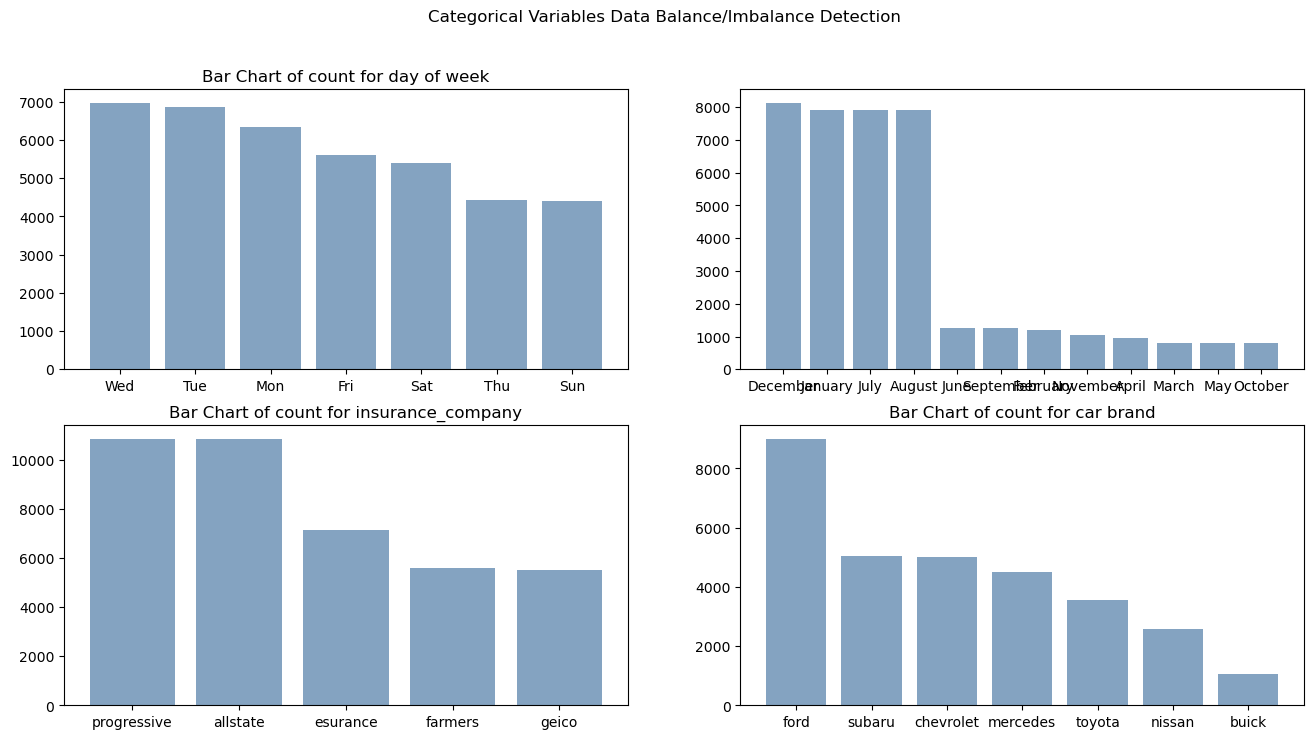

In [13]:
# Create a 2x2 grid of subplots to visualize whether if data imbalance exists
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Plot the data on each subplot
weekday_count = category_df['weekday'].value_counts().reset_index().rename(columns={'index':'dayOfWeek','weekday':'count'})
g1 = axs[0, 0].bar(weekday_count['dayOfWeek'], weekday_count['count'], color=(0.2, 0.4, 0.6, 0.6))
axs[0, 0].set_title('Bar Chart of count for day of week')

month_count = category_df['month'].value_counts().reset_index().rename(columns={'month':'count','index':'month'})
g2 = axs[0, 1].bar(month_count['month'], month_count['count'], color=(0.2, 0.4, 0.6, 0.6))
axs[0, 0].set_title('Bar Chart of count for day of week')

insurance_com_count = category_df['insurance_company'].value_counts().reset_index().rename(columns={'insurance_company':'count','index':'insurance_company'})
g3 = axs[1, 0].bar(insurance_com_count['insurance_company'], insurance_com_count['count'], color=(0.2, 0.4, 0.6, 0.6))
axs[1, 0].set_title('Bar Chart of count for insurance_company')

car_brand_count = category_df['car_brand'].value_counts().reset_index().rename(columns={'car_brand':'count','index':'car_brand'})
g4 = axs[1, 1].bar(car_brand_count['car_brand'], car_brand_count['count'], color=(0.2, 0.4, 0.6, 0.6))
axs[1, 1].set_title('Bar Chart of count for car brand')

# Add a main title
fig.suptitle('Categorical Variables Data Balance/Imbalance Detection')

# Show the plot
plt.show()


In [14]:
category_df_y = pd.concat([category_df,y_df], axis=1)

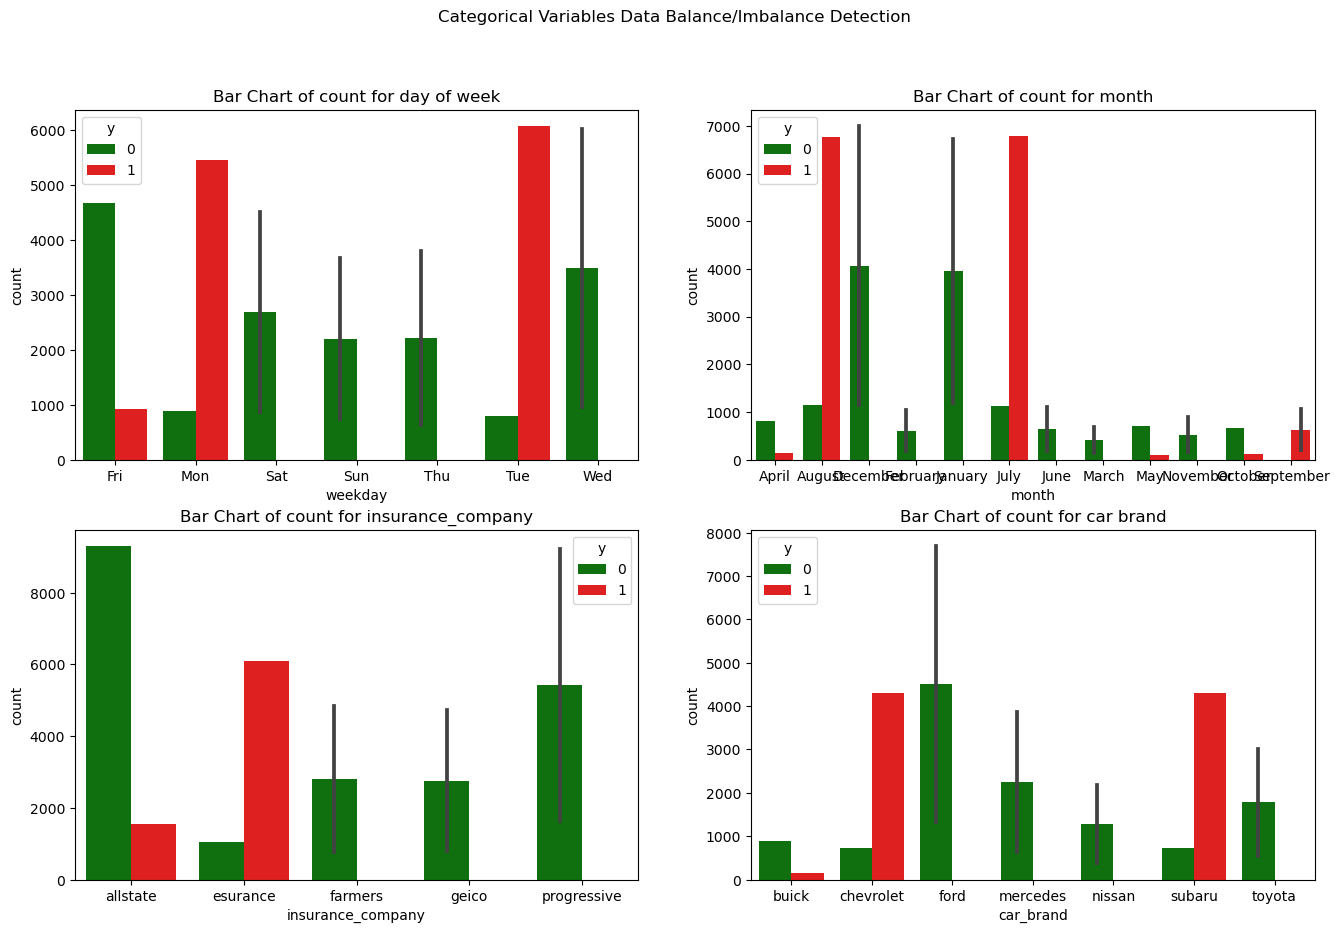

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
colors = ['green', 'red']

# Plot the instance for target value = 1 and 0 on each subplot groupby the cateforical variable
weekday_count = category_df_y.groupby('weekday')['y'].value_counts().to_frame().rename(columns={'y':'count'}).reset_index()
g1 = sns.barplot(x='weekday', y='count', data=weekday_count, hue=data['y'], palette=colors, ax=axs[0, 0])
g1.set_title('Bar Chart of count for day of week')

month_count = category_df_y.groupby('month')['y'].value_counts().to_frame().rename(columns={'y':'count'}).reset_index()
g2 = sns.barplot(x='month', y='count', data=month_count, hue=data['y'], palette=colors, ax=axs[0, 1])
g2.set_title('Bar Chart of count for month')

insurance_com_count = category_df_y.groupby('insurance_company')['y'].value_counts().to_frame().rename(columns={'y':'count'}).reset_index()
g3 = sns.barplot(x='insurance_company', y='count', data=insurance_com_count, hue=data['y'], palette=colors, ax=axs[1, 0])
g3.set_title('Bar Chart of count for insurance_company')

car_brand_count = category_df_y.groupby('car_brand')['y'].value_counts().to_frame().rename(columns={'y':'count'}).reset_index()
g4 = sns.barplot(x='car_brand', y='count', data=car_brand_count, hue=data['y'], palette=colors, ax=axs[1, 1])
g4.set_title('Bar Chart of count for car brand')

# Add a main title
fig.suptitle('Categorical Variables Data Balance/Imbalance Detection')

# Show the plot
plt.show()

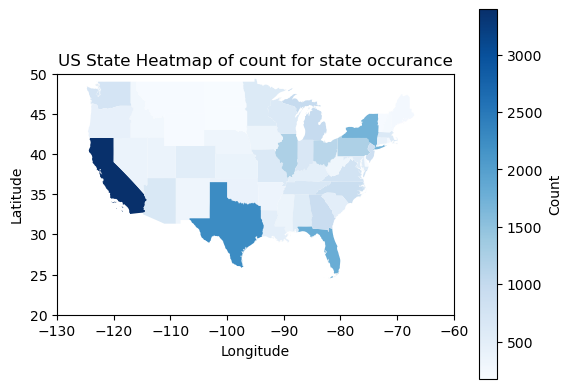

In [16]:
# Load US states shapefile
states = gpd.read_file('geopd/cb_2018_us_state_500k.shp')

def plot_geo(states):
    fig, ax = plt.subplots()
    states.plot(column='count',
                cmap='Blues',
                ax=ax,
                legend=True,
                legend_kwds={'label': 'Count'})
    ax.set_xlim(-130, -60)
    ax.set_ylim(20, 50)
    ax.set_title('US State Heatmap of count for state occurance')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

state_count = category_df['state'].value_counts().to_dict()
states = states.merge(pd.DataFrame({'NAME': list(state_count.keys()),
                                    'count': list(state_count.values())}),
                      on='NAME')    
plot_geo(states)

In [17]:
state_y_mean = category_df_y.groupby('state')['y'].mean()

# Convert the result to a dataframe and rename the column
state_y_percentage = pd.DataFrame(state_y_mean*100).rename(columns={'y': 'y_1_percentage'}).sort_values(by='y_1_percentage', ascending=False).reset_index()

# Testing to make sure the calculation is correct
# a = category_df_y.groupby('state')['y'].value_counts().to_frame().rename(columns={'y':'count'}).reset_index()
# a[a['state'] == 'Alaska'] # returns 0.3125

In [18]:
state_y_percentage

,state,y_1_percentage
0,Alaska,31.250000
1,Idaho,30.324910
2,Oregon,27.654867
3,Washington,26.000000
4,Montana,23.076923
5,Kansas,21.957672
6,North Carolina,21.098901
7,Illinois,19.032258
8,Georgia,18.845316
9,Iowa,18.696884


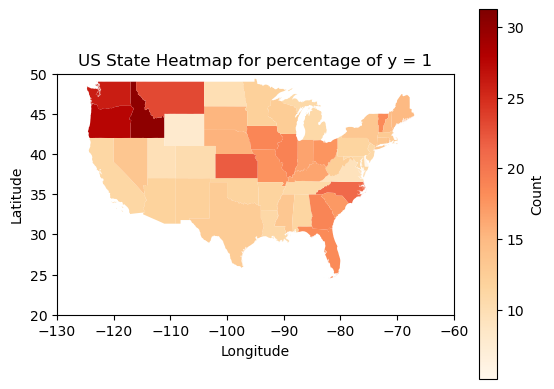

In [19]:
# Load US states shapefile
states = gpd.read_file('geopd/cb_2018_us_state_500k.shp')

def plot_geo(states):
    fig, ax = plt.subplots()
    states.plot(column='count',
                cmap='OrRd',
                ax=ax,
                legend=True,
                legend_kwds={'label': 'Count'})
    ax.set_xlim(-130, -60)
    ax.set_ylim(20, 50)
    ax.set_title('US State Heatmap for percentage of y = 1')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

# state_count = category_df['state'].value_counts().to_dict()
# states = states.merge(pd.DataFrame({'NAME': list(state_y_percentage.keys()),
#                                     'count': list(state_y_percentage.values())}),
#                       on='NAME')    
state_y_percentage = state_y_percentage.set_index('state')['y_1_percentage'].to_dict()
states = states.merge(pd.DataFrame({'NAME': list(state_y_percentage.keys()),
                                    'count': list(state_y_percentage.values())}),
                      on='NAME')    
plot_geo(states)

California, Texas, Florida, and New York are the states that have the highest occurance among all 51 states. However, we do not know the relationship between state and the target value yet.

<Axes: >

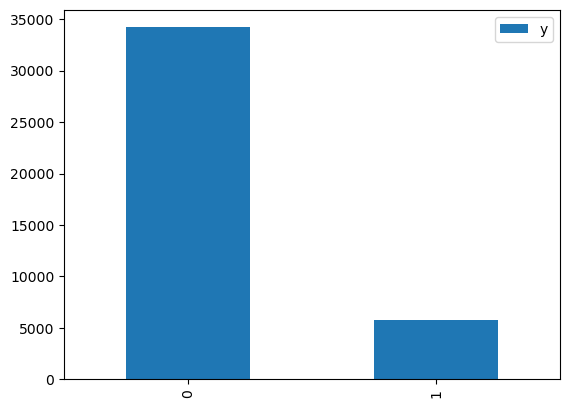

In [20]:
data['y'].value_counts().plot.bar(y='count', legend='target variable')

<Axes: >

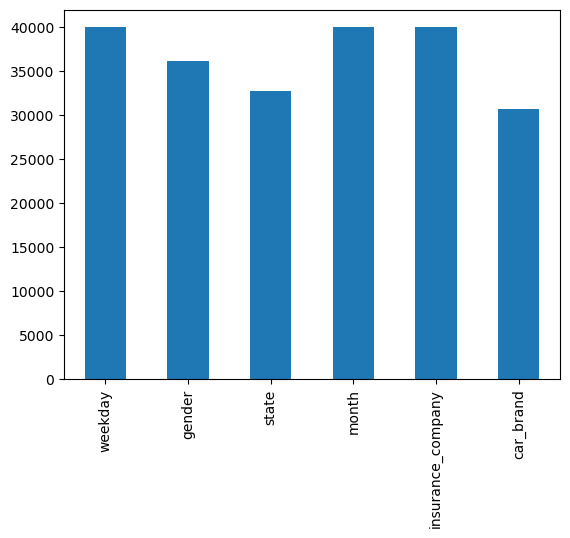

In [21]:
# We can visualize the columns with obvious null values (gender, state, car_brand, x99)
category_df.describe().transpose().plot.bar(y='count', legend=None)

#### Imputation

In [22]:
# Impute categorical missing values using most frequent
def impute_most_frequent(col):
    return col.value_counts().index[0]
category_df = category_df.apply(lambda col: col.fillna(impute_most_frequent(col)))

# Make sure all null values are imputed
category_df.isnull().sum()

weekday              0
gender               0
state                0
month                0
insurance_company    0
car_brand            0
dtype: int64

#### Encode Categorical columns

Perform both Label Encoding and One Hot Encoding. Label Encoder will assign a unique integar value to each category in the variables. While One Hot Encoding creates a new binary feature for each category in the variable.

In [23]:
label_encoders = {col: LabelEncoder() for col in category_df.columns}
cat_df = category_df.copy(deep=True)
for col in category_df.columns:
    cat_df[col] = label_encoders[col].fit_transform(category_df[col])

cat_df.head()

,weekday,gender,state,month,insurance_company,car_brand
0,6,0,5,1,2,3
1,0,1,42,0,0,3
2,4,1,43,11,3,5
3,5,1,23,11,3,4
4,3,1,32,4,3,6


In [24]:
onehot_prefix_pipeline = Pipeline([
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

ct = ColumnTransformer(
    transformers=[('onehot_prefix', onehot_prefix_pipeline, cat_df.columns)],
    remainder='passthrough'
)

data_encoded = pd.DataFrame(ct.fit_transform(cat_df))
column_names = ct.named_transformers_['onehot_prefix'].named_steps['onehot'].get_feature_names_out(cat_df.columns)
data_encoded.columns = column_names.tolist() + cat_df.columns[len(column_names):].tolist()

data_encoded.head()

/home/panda/anaconda3/envs/temp/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,gender_0,gender_1,state_0,...,insurance_company_2,insurance_company_3,insurance_company_4,car_brand_0,car_brand_1,car_brand_2,car_brand_3,car_brand_4,car_brand_5,car_brand_6
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f, pickle.HIGHEST_PROTOCOL)

with open('column_transfomer.pkl', 'wb') as f:
    pickle.dump(ct, f, pickle.HIGHEST_PROTOCOL)

### Numerical Columns

In [26]:
# Combine float_df and int_df
num_df = pd.concat([float_df, int_df], axis=1)
# Imputation
imp = IterativeImputer()
imp_num_df = pd.DataFrame(imp.fit_transform(num_df))
imp_num_df.index = num_df.index
imp_num_df.columns = num_df.columns


In [27]:
# Save the imputation using pickle for later model replication
with open('imputer.pkl', 'wb') as f:
    pickle.dump(imp, f, pickle.HIGHEST_PROTOCOL)

### Combine categorical and numerical dataframe

In [28]:
x_df = pd.concat([data_encoded, imp_num_df], axis=1)
x_df.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,gender_0,gender_1,state_0,...,x96,x97,x100,x7_percentage,x19_money,x59,x98,x31,x93,x99
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,10.255579,7.627730,104.251338,0.0062,-908.650758,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7.882121,10.505284,101.230645,0.0064,-1864.962288,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,8.754572,7.810979,109.345215,-0.0008,-543.187403,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,8.267411,9.178325,103.021970,-0.0057,-182.626381,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,9.987006,11.702664,92.925935,0.0109,967.007091,0.0,0.0,1.0,1.0,1.0


In [29]:
x_df.to_pickle('features.pkl', compression="gzip")